In [3]:
# Import the necessary libraries
import qiskit
from qiskit import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylatexenc
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
import math
import cmath
import random
import copy
import time
from qiskit_aer import Aer

In [4]:
# Note that for the Poisson Problem, the right side is taken as a vector of constants after discretization where
# f = [1,1,1,1,1,1,1,1]^T with two additional boundary points (u(0) and u(1))
def create_b(circuit,qubits):
    for i in qubits:
        circuit.h(i)

def create_b_dagger(circuit, qubits):
    create_b(circuit,qubits)

In [5]:
ansatz_param = None

def create_ansatz(circuit, qubit_list,layers=3,not_final=True):
    param_idx = 0
    for k in range(layers):
        for i in range(len(qubit_list)):
            circuit.ry(ansatz_param[param_idx], qubit_list[i])
            param_idx += 1
        if k == layers-1:
            continue
        if k % 2 == 0:
            if not_final:
                circuit.cz(1,2)
            else:
                circuit.cz(0,1)
        elif k % 2 == 1:
            if not_final:
                circuit.cz(2,1)
            else:
                circuit.cz(1,0)
        else:
            pass

In [6]:
c = [2.0, -1.0, -0.5, -0.5]

I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

a1 = c[0] * np.eye(4)
a2 = c[1] * np.kron(I,X)
a3 = c[2] * np.kron(X,X)
a4 = c[3] * np.kron(Y,Y)

A = a1 + a2 + a3 + a4
b = np.ones(4) / np.sqrt(4)

sol = np.linalg.solve(A,b)
print(sol)

[1. +0.j 1.5+0.j 1.5+0.j 1. +0.j]


In [7]:
def create_A(circuit, idx):
    if idx == 0:
        None
    elif idx == 1:
        circuit.cx(0,2)
    elif idx == 2:
        circuit.cx(0,1)
        circuit.cx(0,2)
    elif idx == 3:
        circuit.cy(0,1)
        circuit.cy(0,2)
    else:
        None

def create_A_dagger(circuit, idx):
    create_A(circuit, idx)

In [14]:
# Specify parameters
from qiskit_aer.noise import NoiseModel

shots = 20000
n_qubit = np.log2(len(b))
n_qubit = int(n_qubit)
backend = Aer.get_backend('qasm_simulator')

# Create the function to evaluate the denominator of the Hadamard Test
def denom_Hadamard(l,lp,part='Re'):
    quantum_circuit = QuantumCircuit(n_qubit+1,1)
    quantum_circuit.h(0)
    
    if part == 'Im':
        quantum_circuit.sdg(0)
    
    create_ansatz(quantum_circuit, [i+1 for i in range(n_qubit)], tot_layers)
    create_A(quantum_circuit,l)
    create_A_dagger(quantum_circuit,lp)

    quantum_circuit.h(0)
    quantum_circuit.measure(0,0)

    job = backend.run(quantum_circuit, shots=shots, memory=False, NoiseModel=None).result()
    result = job.get_counts(quantum_circuit)

    try:
        P0 = result["0"]
        P1 = shots - P0
    except:
        P1 = shots
        P0 = 0
    
    beta_denom = (P0 - P1)/shots
    return beta_denom

# Create the function to evaluate the numerator of the Hadamard Test
def numer_Hadamard(l,lp,j,part="Re"):
    quantum_circuit = QuantumCircuit(n_qubit+1,1)
    quantum_circuit.h(0)

    if part == "Im":
        quantum_circuit.sdg(0)
    
    create_ansatz(quantum_circuit, [i+1 for i in range(n_qubit)], tot_layers)
    create_A(quantum_circuit, l)
    create_b_dagger(quantum_circuit, [i+1 for i in range(n_qubit)])
    quantum_circuit.cz(0,j)
    create_b(quantum_circuit, [i+1 for i in range(n_qubit)])
    create_A_dagger(quantum_circuit, lp)

    quantum_circuit.h(0)
    quantum_circuit.measure(0,0)

    job = backend.run(quantum_circuit, shots=shots, memory=False, NoiseModel=None).result()
    result = job.get_counts(quantum_circuit)

    try:
        P0 = result["0"]
        P1 = shots - P0
    except:
        P1 = shots
        P0 = 0
    
    delta_num = (P0 - P1)/shots
    return delta_num

# Create the function for the classical evaluation of the cost function
def cost_function(ansatz_param_updated):
    global ansatz_param, iteration

    ansatz_param = ansatz_param_updated
    num_sum = 0
    denom_sum = 0
    
    #start = time.time()

    for l in range(len(c)):
        for lp in range(len(c)):
            denom_sum += (c[l] * np.conj(c[lp]) * denom_Hadamard(l,lp,"Re"))
            for j in range(1,n_qubit+1):
                num_sum += (c[l] * np.conj(c[lp]) * numer_Hadamard(l,lp,j,"Re"))
    
    x = 0.5 - 0.5*num_sum/(n_qubit * denom_sum)
    #x = 1 - num_sum*num_sum/denom_sum
    x = abs(x)
    
    #end = time.time()
    
    #print(f'Iteration: {iteration}\tCost Function: {x}\tExecution Time: {end - start}')
    #time_list.append(end - start)
    print(f'Iteration: {iteration}\tCost Function: {x}')
    cost_list.append(x)
    iteration += 1
    return x

### Number of layers in Ansatz Needed:

The below tables(?) show the effectiveness if the number of layers:

layers = 1 (not useful) -- > Not enough parameters for search space (cost function minimization is successful but yields incorrect states)

layers = 2 (not good) --> Cost function minimization successful but incorrect solution

layers = 4 (semi-decent approximation --> Not entirely useful) --> Large error but solution somewhat matches but needs more parameters/shots

layers = 6 --> better results than 4 layer ansatz --> Needs a bigger search space

layers = 8 --> better-ish --> not too good

layers = 10 --> Looks a lot better but maybe needs more parameters for better resolution ---> Best Resolution!

layers = 12 --> Stagnant Cost Function --> Definitely not good! --> Not optimization occurs (Try with double shot number).

layers = 16 --> Similar Results to layers = 10 --> Increasing Parameters seems to not increase the resolution (but this was tried with lower number of shots)

In [15]:
tot_layers = 16
x_num = (sol/np.linalg.norm(sol,2))**2
iteration = 1
cost_list = []
theta0 = [random.random() * 2 * np.pi for i in range(tot_layers * n_qubit)]
minimize(cost_function, x0=theta0, args=(), method='COBYLA', options={'maxiter':500, "rhobeg":np.pi/4})

Iteration: 1	Cost Function: 0.8024595505503569
Iteration: 2	Cost Function: 0.7286418314372866
Iteration: 3	Cost Function: 0.9066199862684159
Iteration: 4	Cost Function: 0.849725525118737
Iteration: 5	Cost Function: 0.6852980458506969
Iteration: 6	Cost Function: 0.7408654982858495
Iteration: 7	Cost Function: 0.7935493394810074
Iteration: 8	Cost Function: 0.5830781473011059
Iteration: 9	Cost Function: 0.5067396174506885
Iteration: 10	Cost Function: 0.5019265107569952
Iteration: 11	Cost Function: 0.5073380896365377
Iteration: 12	Cost Function: 0.5078307741394283
Iteration: 13	Cost Function: 0.510426831961897
Iteration: 14	Cost Function: 0.5052827367748576
Iteration: 15	Cost Function: 0.5136065594888443
Iteration: 16	Cost Function: 0.5546017488758641
Iteration: 17	Cost Function: 0.5259896737661434
Iteration: 18	Cost Function: 0.49958396092768464
Iteration: 19	Cost Function: 0.5211955053392919
Iteration: 20	Cost Function: 0.5356894030267676
Iteration: 21	Cost Function: 0.5266588167719701
It

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.027769370460049236
       x: [ 2.455e+00  3.438e+00 ...  2.597e+00  5.575e-02]
    nfev: 304
   maxcv: 0.0

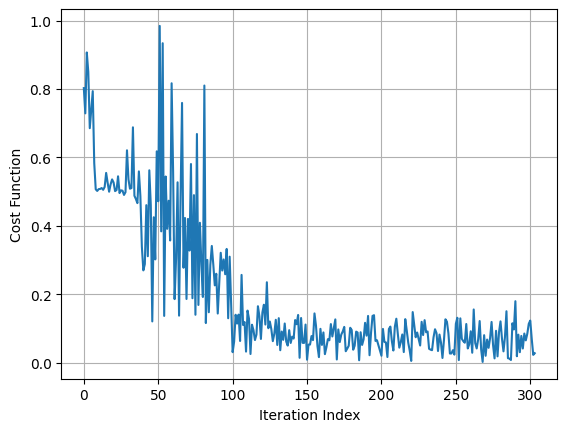

In [16]:
plt.plot(cost_list)
plt.xlabel('Iteration Index')
plt.ylabel('Cost Function')
plt.grid()
plt.show()

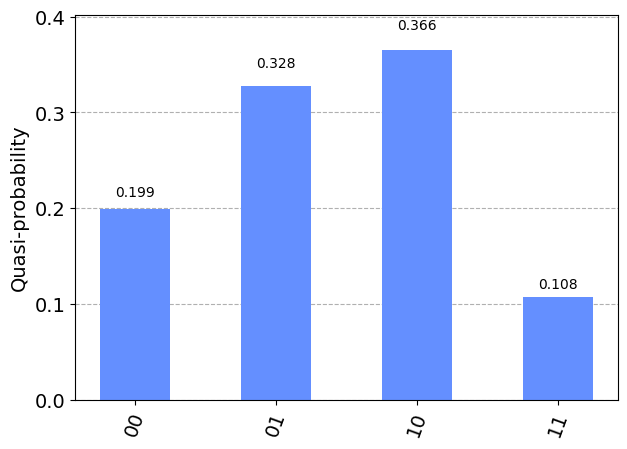

In [17]:
#For 4 layers - ansatz_param = [3.454e+00, 6.545e-01, 6.697e+00, 6.953e+00, 3.135e+00, 2.139e+00, 2.349e+00, 5.551e+00]
#ansatz_param = [5.133e+00, 1.648e+00, 4.014e+00, 3.322e+00, 4.505e+00, 3.769e+00, 6.427e+00, 4.317e+00, 6.761e+00, 3.337e+00, 4.421e+00, 5.485e+00]
qc_final = QuantumCircuit(n_qubit)
create_ansatz(qc_final, [0,1], tot_layers, False)
qc_final.measure_all()
job = backend.run(qc_final, shots=100*shots, memory=False).result()
results = job.get_counts(0)
for key in results:
    results[key] *= (0.01/shots)
plot_histogram(results)

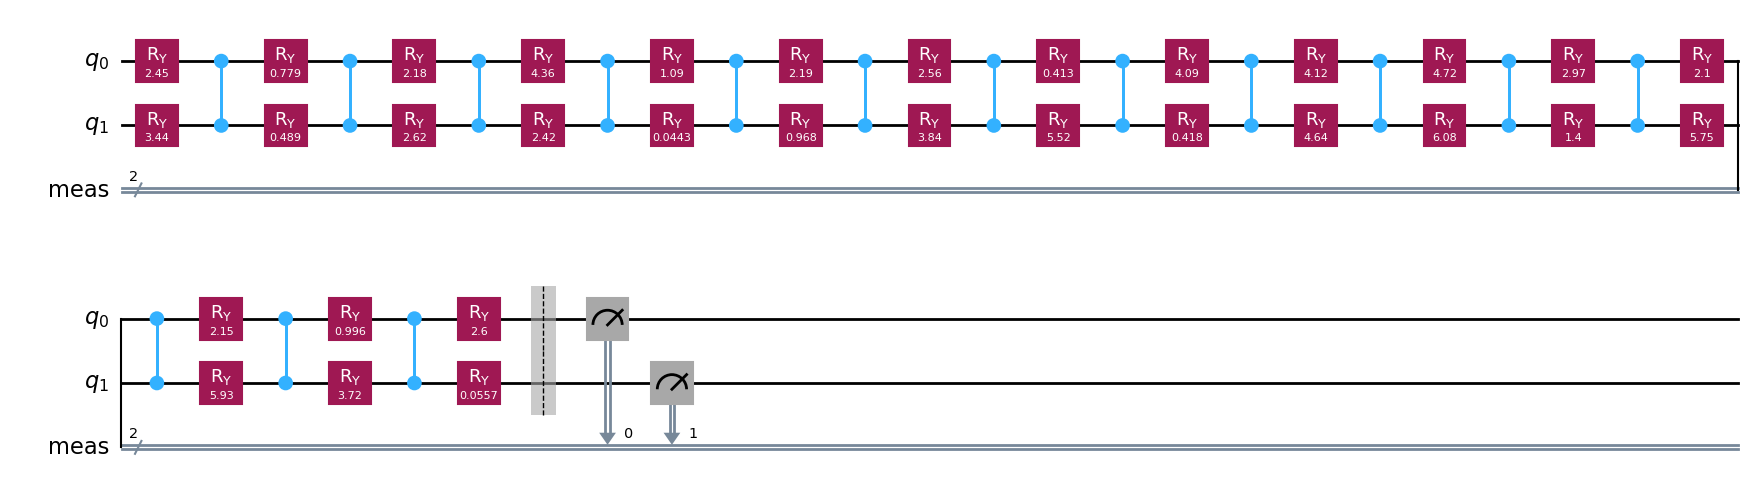

In [18]:
qc_final.draw('mpl')

In [ ]:
np.savetxt('Opt_Params_Poisson_4x4.txt', ansatz_param)

In [19]:
x_num = (sol/np.linalg.norm(sol,2))**2
print(x_num)

[0.15384615+0.j 0.34615385+0.j 0.34615385+0.j 0.15384615+0.j]


In [ ]:
x_quant = np.zeros(4)
for i in range(4):
    key = bin(i)[2:]
    if len(key) < 2:
        key = '0' * (2 - len(key)) + key
    x_quant[i] = counts[str(key)]
print(f'Error Norm: {np.linalg.norm(x_quant - x_num,2)}\tMax Error:{max(abs(x_quant - x_num))}')

Error Norm: 0.08452992004165456	Max Error:0.062343846153846166


In [ ]:
x_quant

array([0.1511    , 0.35457611, 0.34289278, 0.15143111])

## Gradient Based Approach to Minimization

In [ ]:
def cost_function_gradient(ansatz_param_updated, *args):
    global ansatz_param
    params = copy.deepcopy(ansatz_param_updated)
    num_sum = 0
    denom_sum = 0
    gradient = []
    g = 0
    f = 0
    ansatz_param = ansatz_param_updated
    
    for l in range(len(c)):
        for lp in range(len(c)):
            g += (c[l] * np.conj(c[lp]) * denom_Hadamard(l,lp,'Re'))
            for j in range(1,n_qubit+1):
                f += (c[l] * np.conj(c[lp]) * numer_Hadamard(l,lp,j,'Re'))
    
    for i in range(len(params)):
        pos_g = 0
        pos_f = 0
        neg_g = 0
        neg_f = 0
        
        pos_ansatz_param = copy.deepcopy(params)
        pos_ansatz_param[i] = pos_ansatz_param[i] + np.pi/2
        ansatz_param = pos_ansatz_param
        
        for l in range(len(c)):
            for lp in range(len(c)):
                pos_g += (c[l] * np.conj(c[lp]) * denom_Hadamard(l,lp,'Re'))
                for j in range(1,n_qubit+1):
                    pos_f += (c[l] * np.conj(c[lp]) * numer_Hadamard(l,lp,j,'Re'))
        
        neg_ansatz_param = copy.deepcopy(params)
        neg_ansatz_param[i] = neg_ansatz_param[i] - np.pi/2
        ansatz_param = neg_ansatz_param
        
        for l in range(len(c)):
            for lp in range(len(c)):
                neg_g += (c[l] * np.conj(c[lp]) * denom_Hadamard(l,lp,'Re'))
                for j in range(1,n_qubit+1):
                    neg_f += (c[l] * np.conj(c[lp]) * numer_Hadamard(l,lp,j,'Re'))
        
        dg = 0.5 * (pos_g - neg_g)
        df = 0.5 * (pos_f - neg_f)
        dc = -1/(2*n_qubit) * (g * df - f * dg)/(g*g)
        
        if dc < 0:
            dc = -1*abs(dc)
        else:
            dc = abs(dc)
        gradient.append(dc)
    ansatz_param = params
    return gradient

In [ ]:
tot_layers = 8
theta = [random.random() * 2 * np.pi for i in range(tot_layers * n_qubit)]
cost_list = []
time_list = []
iteration = 1
minimize(cost_function, x0=theta, jac=cost_function_gradient, args=(), method='SLSQP', options={'maxiter':500})

Iteration: 1	Cost Function: 0.9575903712108933
Iteration: 2	Cost Function: 0.8870532703978424
Iteration: 3	Cost Function: 0.5498260510643316
Iteration: 4	Cost Function: 0.7115306783228104
Iteration: 5	Cost Function: 0.4827430887900456
Iteration: 6	Cost Function: 0.4904252155813262
Iteration: 7	Cost Function: 0.49148179749715587
Iteration: 8	Cost Function: 0.49485949280328995
Iteration: 9	Cost Function: 0.5018175157799819
Iteration: 10	Cost Function: 0.49955870629768817
Iteration: 11	Cost Function: 0.49270187219029193
Iteration: 12	Cost Function: 0.49980163228292906
Iteration: 13	Cost Function: 0.5020401846015309
Iteration: 14	Cost Function: 0.49948956442831216
Iteration: 15	Cost Function: 0.5016329660343065
Iteration: 16	Cost Function: 0.498372764319674


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.498372764319674
       x: [ 5.103e+00 -5.733e-01 ...  3.515e+00 -4.607e-01]
     nit: 4
     jac: [-6.807e-03 -2.045e-02 ...  2.072e-02 -3.337e-03]
    nfev: 16
    njev: 4

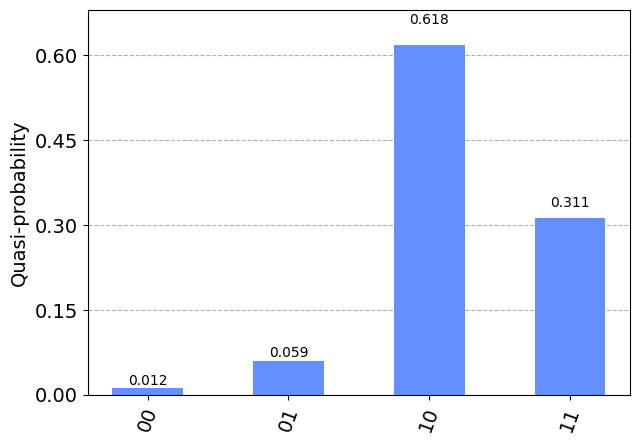

In [ ]:
#For 4 layers - ansatz_param = [3.454e+00, 6.545e-01, 6.697e+00, 6.953e+00, 3.135e+00, 2.139e+00, 2.349e+00, 5.551e+00]
#ansatz_param = [5.133e+00, 1.648e+00, 4.014e+00, 3.322e+00, 4.505e+00, 3.769e+00, 6.427e+00, 4.317e+00, 6.761e+00, 3.337e+00, 4.421e+00, 5.485e+00]
qc_final = QuantumCircuit(n_qubit)
create_ansatz(qc_final, [0,1], tot_layers, False)
qc_final.measure_all()
results = execute(qc_final, backend=backend, shots=10*shots, noise_model=noise_model)
counts = results.result().get_counts()
for key in counts:
    counts[key] *= (1/shots)/10
plot_histogram(counts)

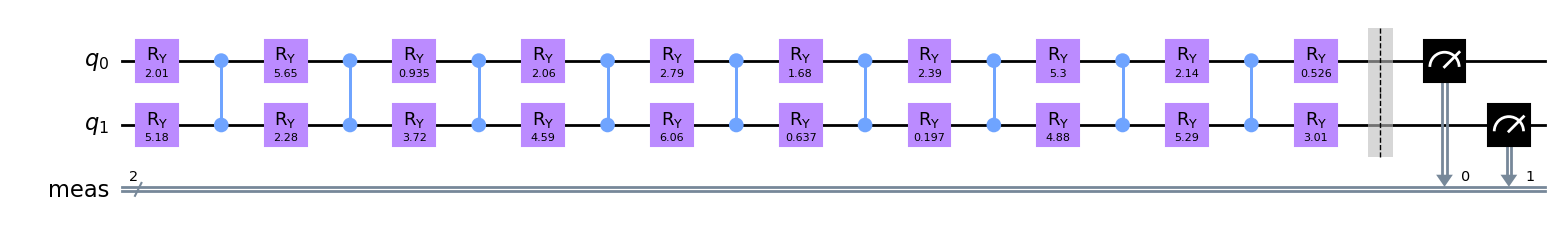

In [ ]:
qc_final.draw('mpl')